In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp, binned_statistic
from settings import (colors, titles, ax_label_size, tick_label_size,
                      letter_size, legend_size, lw, line_alpha, fill_alpha)
from settings import (plot_lower, plot_upper, stats_frac_lower,
                      stats_frac_upper, select_lower, select_upper,
                      p_lower, p_upper, stats_frac_middle,
                      ci, title_pad)

In [2]:
ccycle = mplego.colors.get_default_ccycle()

In [3]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"
loc = 'data'
loc = 'noise_correlations'

In [4]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')
roi_path = os.path.join(f"/storage/{loc}/ret2/roi_positions.mat")

In [5]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [6]:
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
n_results = len(results)

# FF and ND

In [7]:
with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)
    
with open(os.path.join(base_path, f'exp{exp}_cdfs.pkl'), 'rb') as f:
    all_null_equiv_cdfs, all_opt_fa_equiv_cdfs, all_opt_equiv_cdfs = pickle.load(f)

# Calculate correlations between max CDFs and percentiles
fa_ff_corrs = np.zeros((len(results), dims.size))
fa_nd_corrs = np.zeros((len(results), dims.size))

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        fa_ff_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.log(opt_fa_ffs[result_idx][dim_idx]) - np.log(obs_ffs[result_idx][dim_idx]),
        ).correlation
        fa_nd_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1) - np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation

dim_idx = 0
dim = dim_idx + 3
# Maximum values
max_null_cdfs = [np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
                 for result_idx in range(n_results)]
max_opt_fa_cdfs = [np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
                   for result_idx in range(n_results)]

In [8]:
fa_cdf_mse = []
fa_cdf_rank = []
fa_ff_mse = []
fa_ff_rank = []
avg_rank = []
best_obs_p_rank = np.zeros((3, 18, 3))

for result_idx, result in enumerate(results):
    fa_ff_mse.append((opt_fa_ffs[result_idx] - obs_ffs[result_idx])**2)
    fa_ff_rank.append(np.argsort(-fa_ff_mse[-1], axis=-1))
    ff_mse_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        fa_max = np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
        equiv_max = np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
        ff_mse_temp[dim_idx] = (fa_max - equiv_max)**2
    fa_cdf_mse.append(ff_mse_temp)
    fa_cdf_rank.append(np.argsort(-fa_cdf_mse[-1], axis=-1))
    avg_rank.append(0.5 * (fa_ff_rank[-1] + fa_cdf_rank[-1]))
    
    # Grab observed percentiles for best avg ranks
    best_obs_p_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        avg_rank_temp = avg_rank[-1][dim_idx]
        rank_lower, rank_upper = np.percentile(avg_rank_temp, q=[select_lower, select_upper])
        p_fa_lfi_slice = result['p_fa_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        best_obs_p_rank[result_idx, dim_idx] = utils.run_bootstrap(p_fa_lfi_slice, np.median, ci)

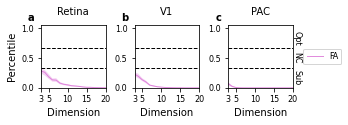

In [10]:
"""
Figure Settings
"""

model_labels = ['Observed', 'FA']
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}
bins = [
    np.linspace(-1.5, -0.75, 30),
    np.linspace(0, 1.2, 30),
    np.linspace(0, 1.5, 30)
]
labels = [
    'Uniform',
    'FA'
]
percentile_groups = [
    'p_u_lfi',
    'p_fa_lfi'
]
models = [
    'uniform',
    'fa'
]

"""
Figure 6
"""
figsize = (5, 1.5)
fig = plt.figure(figsize=figsize)
le = .15
re = .15
te = .17
be = .25
h = .15
hg = .08
w = (1. - le - re - 2.*hg) / 3.
h = (1. - te - be)

axes = np.empty(3, dtype=object)
axes[:] = [fig.add_axes([le + jj*(w + hg), be, w, h]) for jj in range(3)]


for idx, result in enumerate(results):
    # Average rank over dimensions
    axes[idx].plot(
        dims,
        best_obs_p_rank[idx, :, 1],
        linewidth=lw,
        alpha=line_alpha,
        color=colors['fa'],
        label=labels[1])

    axes[idx].fill_between(
        x=dims,
        y1=best_obs_p_rank[idx, :, 0],
        y2=best_obs_p_rank[idx, :, 2],
        color=colors['fa'],
        alpha=fill_alpha,
        ec='none')
    axes[idx].axhline(plot_lower, linestyle='--', color='k', lw=lw)
    axes[idx].axhline(plot_upper, linestyle='--', color='k', lw=lw)
    
axes[2].text(21, 5/6, 'Opt', va='center', ha='center', rotation=-90, fontsize=tick_label_size)
axes[2].text(21, 3/6, 'NC', va='center', ha='center', rotation=-90, fontsize=tick_label_size)
axes[2].text(21, 1/6, 'Sub', va='center', ha='center', rotation=-90, fontsize=tick_label_size)


for ax in axes.ravel():
    ax.set_xlim([3, 20])
    ax.set_ylim([0, 1.05])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_label_size)
    ax.set_xlabel('Dimension', fontsize=ax_label_size)
axes[0].set_ylabel('Percentile', fontsize=ax_label_size)
axes[0].set_title(r'Retina', fontsize=ax_label_size, pad=title_pad)
axes[1].set_title(r'V1', fontsize=ax_label_size, pad=title_pad)
axes[2].set_title(r'PAC', fontsize=ax_label_size, pad=title_pad)

axes[2].legend(loc='center left', fontsize=legend_size, bbox_to_anchor=(1.1, 0.5))


# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
c = 0
for ii in range(3):
    ax = axes[ii]
    ax.text(-.2, 1.07, lets[c], size=letter_size, fontweight='bold',
            transform=ax.transAxes)
    c += 1
# for ax in caxes:
#     ax.tick_params(labelsize=tick_label_size)

plt.savefig('supp4.pdf', dpi=300)
plt.savefig('supp4.jpg', dpi=300)

plt.show()